## Fit PDF


In [1]:
# load csv
import pandas as pd

df = pd.read_csv('../customer_support_tickets.csv')

In [2]:
# drop first response time Null/Nan and Time to resolution NaN/Null
df.dropna(inplace=True)

df['First Response Time'] = df['First Response Time'].apply(lambda x: x.replace(' ', 'T').strip())
df['Time to Resolution'] = df['First Response Time'].apply(lambda x: x.replace(' ', 'T').strip())


In [3]:
# convert to datetime
df['First Response Time'] = pd.to_datetime(df['First Response Time'])
df['Time to Resolution'] = pd.to_datetime(df['Time to Resolution'])

In [4]:
df.head()

,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,2023-06-01 11:14:38,2023-06-01 11:14:38,3.0
3,4,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Try capital clearly never color toward story.,Low,Social media,2023-06-01 07:29:40,2023-06-01 07:29:40,3.0
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,2023-06-01 00:12:42,2023-06-01 00:12:42,1.0
10,11,Joseph Moreno,mbrown@example.org,48,Male,Nintendo Switch,2021-01-19,Cancellation request,Data loss,I'm having an issue with the {product_purchase...,Closed,Measure tonight surface feel forward.,High,Phone,2023-06-01 17:46:49,2023-06-01 17:46:49,1.0
11,12,Brandon Arnold,davisjohn@example.net,51,Male,Microsoft Xbox Controller,2021-10-24,Product inquiry,Software bug,I'm having an issue with the {product_purchase...,Closed,Measure there house management pick knowledge ...,High,Chat,2023-06-01 12:05:51,2023-06-01 12:05:51,1.0


In [18]:
data = pd.DataFrame()
data['First Response Time'] = df['First Response Time']
# we only care about the minutes
data['ia_minutes'] = data['First Response Time'].apply(lambda x: x.hour * 60 + x.minute)
data.head()

,First Response Time,ia_minutes
2,2023-06-01 11:14:38,674
3,2023-06-01 07:29:40,449
4,2023-06-01 00:12:42,12
10,2023-06-01 17:46:49,1066
11,2023-06-01 12:05:51,725


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gausshyper,0.000002,1466.389882,1501.947331,0.019318,0.009769,0.951869
beta,0.000002,1462.506606,1486.211572,0.019418,0.016274,0.450953
wrapcauchy,0.000002,1460.351323,1478.130047,0.019541,0.013098,0.723856
truncpareto,0.000002,1466.002790,1489.707756,0.019419,0.020453,0.194334
uniform,0.000002,1458.340741,1470.193224,0.019603,0.014728,0.580024


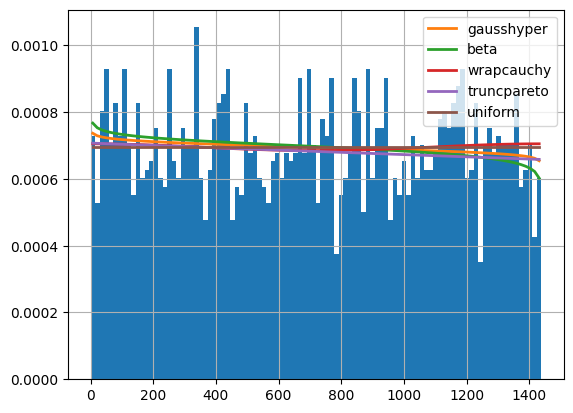

In [19]:
from fitter import Fitter

f = Fitter(data['ia_minutes'])
f.fit()
# may take some time since by default, all distributions are tried,
# but you call manually provide a smaller set of distributions
f.summary()

In [20]:
best_params_arrivals = f.get_best(method='sumsquare_error')
print(best_params_arrivals)

{'gausshyper': {'a': 0.9910362774479069, 'b': 1.0099981446827868, 'c': 0.025175633618362295, 'z': 1.0571446468675616, 'loc': -1.0356876597441011e-16, 'scale': 1439.0049867249868}}


In [21]:
from scipy import stats

ia = stats.gausshyper.rvs(**best_params_arrivals.get('gausshyper'), size=4_000)

gen = pd.DataFrame()
gen['ia'] = ia

In [17]:
gen.head()

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


,ia
0,2023-06-01 22:26:21.498765230
1,2023-06-01 14:54:05.838084936
2,2023-06-01 19:38:42.450662613
3,2023-05-31 22:50:46.602593422
4,2023-06-01 16:11:21.628497839


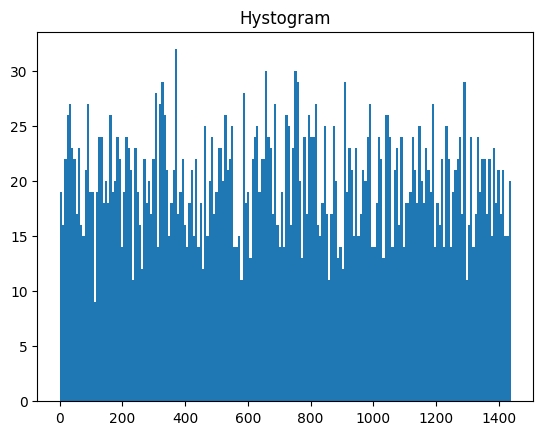

In [23]:
import matplotlib.pyplot as plt

plt.title('Arrivals')
plt.xlabel('Minutes')
plt.hist(gen['ia'], bins=200)
plt.show()

In [24]:
# same for resolution time
data['Time to Resolution'] = df['Time to Resolution']
data['ta_minutes'] = data['Time to Resolution'].apply(lambda x: x.hour * 60 + x.minute)

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gausshyper,0.000002,1466.389882,1501.947331,0.019318,0.009769,0.951869
beta,0.000002,1462.506606,1486.211572,0.019418,0.016274,0.450953
wrapcauchy,0.000002,1460.351323,1478.130047,0.019541,0.013098,0.723856
truncpareto,0.000002,1466.002790,1489.707756,0.019419,0.020453,0.194334
uniform,0.000002,1458.340741,1470.193224,0.019603,0.014728,0.580024


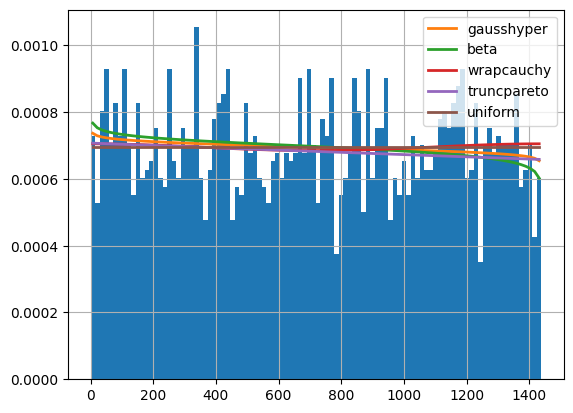

In [25]:
f = Fitter(data['ta_minutes'])
f.fit()
f.summary()

In [26]:
# The best fit is the gausshyper distribution, but we can also try the beta distribution
beta_params = f.fitted_param['beta']
print(beta_params)

(0.983590412352064, 1.0292732862063347, -4.9879476640868376e-23, 1439.015558070154)


In [27]:
ta = stats.beta.rvs(*beta_params, size=4_000)
gen['ta'] = ta

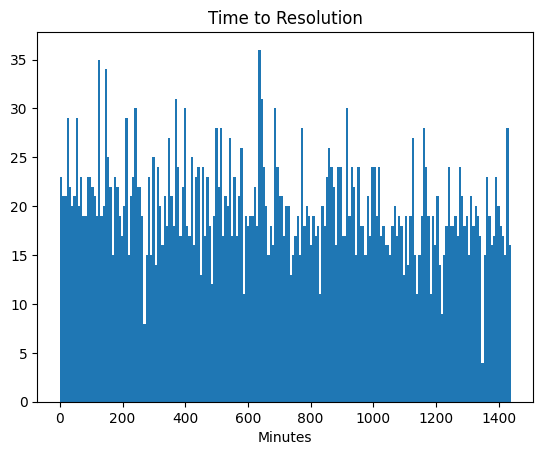

In [28]:
plt.title('Time to Resolution')
plt.xlabel('Minutes')
plt.hist(gen['ta'], bins=200)
plt.show()